In [1]:
import os
import cv2
import time
import random
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
version = '18'
main_path = f'/kaggle/input/workout-model-collection/version {version}'

# tflite
for file in os.listdir(main_path):
    if file.endswith('.tflite'):
        model_file_path = os.path.join(main_path, file)
        print(model_file_path)
        
# h5
for file in os.listdir(main_path):
    if file.endswith('.h5'):
        workout_model = load_model(os.path.join(main_path, file))
        print(os.path.join(main_path, file))

/kaggle/input/workout-model-collection/version 18/workout_model2023-03-10 17_47_49.549102.tflite
/kaggle/input/workout-model-collection/version 18/workout_model_2023-03-10 17_47_49.549102.h5


In [3]:
interpreter = tf.lite.Interpreter(model_path = model_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
random_classes_names = random.choice(os.listdir('../input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'../input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'../input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open(f'/kaggle/input/workout-model-collection/version {version}/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

shoulder press/shoulder press_7.mp4

Duration: 10.5105
FPS: 29.97002997002997
Total frame: 315.0

Prediction process
1, shoulder press
	0.99539715051651
31, shoulder press
	0.8947255611419678
61, shoulder press
	0.9271162152290344

Actual video: shoulder press_7.mp4
Prediction: shoulder press

confidence: 0.9271162152290344
Prediction time: 0.9785501956939697 sec


,exercise,percentage
0,shoulder press,9.271162e-01
1,lat pulldown,4.819356e-02
2,chest fly machine,1.333131e-02
3,incline bench press,6.425865e-03
4,decline bench press,2.975922e-03
5,bench press,8.631088e-04
6,tricep dips,3.495749e-04
7,pull up,1.696291e-04
8,leg raises,1.305856e-04
9,barbell biceps curl,1.196785e-04


# Confussion Matrix

In [5]:
DATA_DIR = '/kaggle/input/workoutexercises-images'

count = 0

for root_dir, cur_dir, files in os.walk('/kaggle/input/workoutexercises-images'):
    count += len(files)

val_split = 0.25
batch = int(val_split*count)
    
ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                 labels='inferred',
                                                 label_mode='categorical',
                                                 image_size=img_size,
                                                 shuffle=True,
                                                 subset='validation',
                                                 validation_split=val_split,
                                                 batch_size=batch,
                                                 seed=127
                                                )

#define labels for testing
for images, test_labels in ds.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
    y_labels = test_labels.numpy()

y_labels = np.argmax(y_labels, axis=1)

#make prediction
y_preds = np.argmax(workout_model.predict(ds), axis=1)

#get classification report
print(classification_report(y_labels, y_preds, target_names=labels))

Found 13853 files belonging to 22 classes.
Using 3463 files for validation.
1/1 [==============================] - 300s 300s/step
                      precision    recall  f1-score   support

barbell biceps curl
       0.04      0.03      0.04       180
        bench press
       0.07      0.06      0.07       156
  chest fly machine
       0.04      0.05      0.04       146
           deadlift
       0.03      0.03      0.03       131
decline bench press
       0.07      0.07      0.07       133
        hammer curl
       0.02      0.02      0.02       135
         hip thrust
       0.03      0.02      0.02       138
incline bench press
       0.08      0.08      0.08       183
       lat pulldown
       0.06      0.07      0.06       153
     lateral raises
       0.06      0.06      0.06       223
      leg extension
       0.02      0.03      0.02       153
         leg raises
       0.06      0.05      0.06       131
              plank
       0.07      0.07      0.07       217
 

In [6]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,12))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

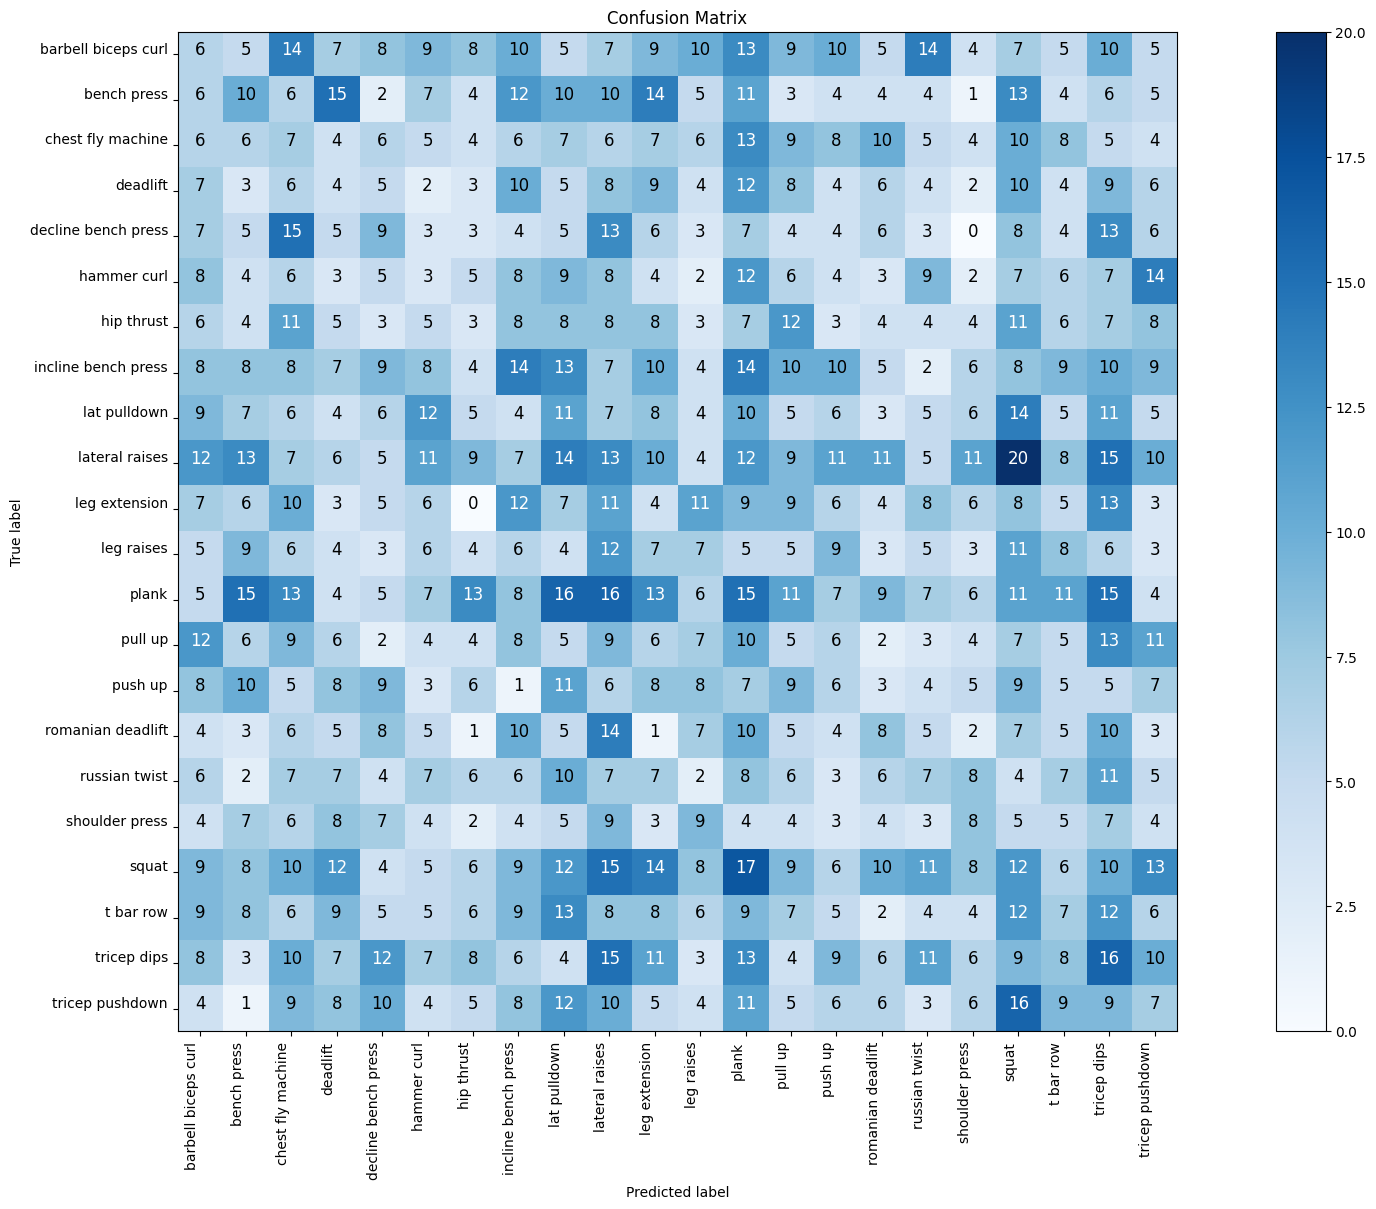

In [7]:
#get confusion matrix
cm = confusion_matrix(y_labels, y_preds)
# print(cm)

#plot
plot_confusion_matrix(cm, labels, normalize=False)

In [8]:
print(f'F1 score for version {version}\n')

#F1 score
print('macro: ', f1_score(y_labels, y_preds, average='macro'))
print('micro: ', f1_score(y_labels, y_preds, average='micro'))
print('weighted: ', f1_score(y_labels, y_preds, average='weighted'))
print('None: ', f1_score(y_labels, y_preds, average=None))

F1 score for version 18

macro:  0.05148112977382004
micro:  0.05255558764077389
weighted:  0.05240871966819089
None:  [0.03571429 0.06688963 0.04255319 0.02941176 0.06792453 0.02281369
 0.0242915  0.07932011 0.06395349 0.05882353 0.02461538 0.05511811
 0.06726457 0.03355705 0.0433213  0.06451613 0.05343511 0.07239819
 0.05542725 0.04666667 0.07881773 0.04575163]
